In [8]:
import numpy as np
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys

In [2]:
with open('learning_rates.json', 'r') as file:
    results = json.load(file)

In [3]:

def analyze_results(results):
    for name, data in results.items():
        final_loss = data['losses'][-1]
        avg_loss = np.mean(data['losses'])
        avg_norm = np.mean(data['norms'])
        total_time = sum(data['times'])
        
        converged_step = data['converged_step']
        convergence_speed = "Did not converge" if converged_step is None else f"Step {converged_step}"
        
        # Training Stability
        loss_std = np.std(data['losses'])
        stability_score = 1 / (1 + loss_std)  # Higher score means more stable
        
        print(f"{name} Scheduler:")
        print(f"  Final Loss: {final_loss:.6f}")
        print(f"  Average Loss: {avg_loss:.6f}")
        print(f"  Average Gradient Norm: {avg_norm:.6f}")
        print(f"  Convergence Speed: {convergence_speed}")
        print(f"  Training Stability Score: {stability_score:.4f}")
        print(f"  Total Training Time: {total_time:.2f} seconds")
        print()

    # Compare resource usage
    total_times = {name: sum(data['times']) for name, data in results.items()}
    fastest_scheduler = min(total_times, key=total_times.get)
    slowest_scheduler = max(total_times, key=total_times.get)
    print(f"Fastest scheduler: {fastest_scheduler} ({total_times[fastest_scheduler]:.2f} seconds)")
    print(f"Slowest scheduler: {slowest_scheduler} ({total_times[slowest_scheduler]:.2f} seconds)")

analyze_results(results)

Constant Scheduler:
  Final Loss: 5.853835
  Average Loss: 6.503897
  Average Gradient Norm: 1.705478
  Convergence Speed: Step 13
  Training Stability Score: 0.4972
  Total Training Time: 1972.76 seconds

Step Scheduler:
  Final Loss: 5.151307
  Average Loss: 5.534471
  Average Gradient Norm: 0.493683
  Convergence Speed: Step 1
  Training Stability Score: 0.8183
  Total Training Time: 2364.65 seconds

MultiStep Scheduler:
  Final Loss: 4.607251
  Average Loss: 4.868881
  Average Gradient Norm: 0.839494
  Convergence Speed: Step 15
  Training Stability Score: 0.8611
  Total Training Time: 2397.08 seconds

Exponential Scheduler:
  Final Loss: 4.263788
  Average Loss: 4.406377
  Average Gradient Norm: 0.883760
  Convergence Speed: Step 6
  Training Stability Score: 0.9187
  Total Training Time: 2336.36 seconds

CosineAnnealing Scheduler:
  Final Loss: 4.081490
  Average Loss: 4.256855
  Average Gradient Norm: 1.893919
  Convergence Speed: Step 4
  Training Stability Score: 0.8792
  Tota

In [21]:

def generate_distinct_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.7, 0.9) for x in range(n)]
    return list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

def plot_individual_metric(results, metric, title, y_axis_title, log_scale=False):
    n_schedulers = len(results)
    colors = generate_distinct_colors(n_schedulers)
    
    fig = go.Figure()

    for idx, (name, data) in enumerate(results.items()):
        color = f'rgb({",".join(map(str, [int(255*x) for x in colors[idx]]))})'
        
        y_data = data[metric]
        x_data = list(range(len(y_data)))
        
        fig.add_trace(
            go.Scatter(
                x=x_data, 
                y=y_data,
                mode='lines', 
                name=name, 
                line=dict(color=color, width=3),
                hovertemplate=f'{name}<br>Step: %{{x}}<br>{y_axis_title}: %{{y:.4f}}<extra></extra>'
            )
        )
        
        stability_score = 1 / (1 + np.std(data['losses']))
        converged_step = data['converged_step']
        convergence_text = f"Step {converged_step}" if converged_step is not None else "Did not converge"

        fig.add_annotation(
            text=f"<b>{name}</b><br>Stability: {stability_score:.4f}<br>Convergence: {convergence_text}",
            xref="paper", yref="paper",
            x=1.02, y=0.98 - (idx * 0.1), 
            showarrow=False,
            font=dict(size=12, color=color),
            align="left", 
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor=color,
            borderwidth=2,
            borderpad=4
        )

    fig.update_layout(
        height=600, width=900, 
        title_text=f"<b>{title}</b>",
        title_font=dict(size=24),
        showlegend=True,
        legend=dict(font=dict(size=14)),
        hovermode="x unified",
        plot_bgcolor='rgba(250,250,250,0.9)',
        paper_bgcolor='rgba(250,250,250,0.9)',
        font=dict(family="Arial", size=16, color="#444"),
    )

    fig.update_xaxes(title_text="<b>Step</b>", gridcolor='white', gridwidth=2)
    fig.update_yaxes(title_text=f"<b>{y_axis_title}</b>", gridcolor='white', gridwidth=2)
    
    if log_scale:
        fig.update_yaxes(type="log")

    fig.show()

def plot_results(results):
    # Plot Training Loss
    plot_individual_metric(results, 'losses', "Training Loss", "Loss", log_scale=True)
    
    # Plot Learning Rate Schedule
    plot_individual_metric(results, 'lrs', "Learning Rate Schedule", "Learning Rate", log_scale=True)
    
    # Plot Gradient Norm
    plot_individual_metric(results, 'norms', "Gradient Norm", "Gradient Norm")
    
    # Plot Cumulative Training Time
    cumulative_times = {name: np.cumsum(data['times']) for name, data in results.items()}
    cumulative_results = {name: {'times': times} for name, times in cumulative_times.items()}
    plot_individual_metric(cumulative_results, 'times', "Cumulative Training Time", "Time (s)")

In [22]:
plot_results(results)

KeyError: 'losses'

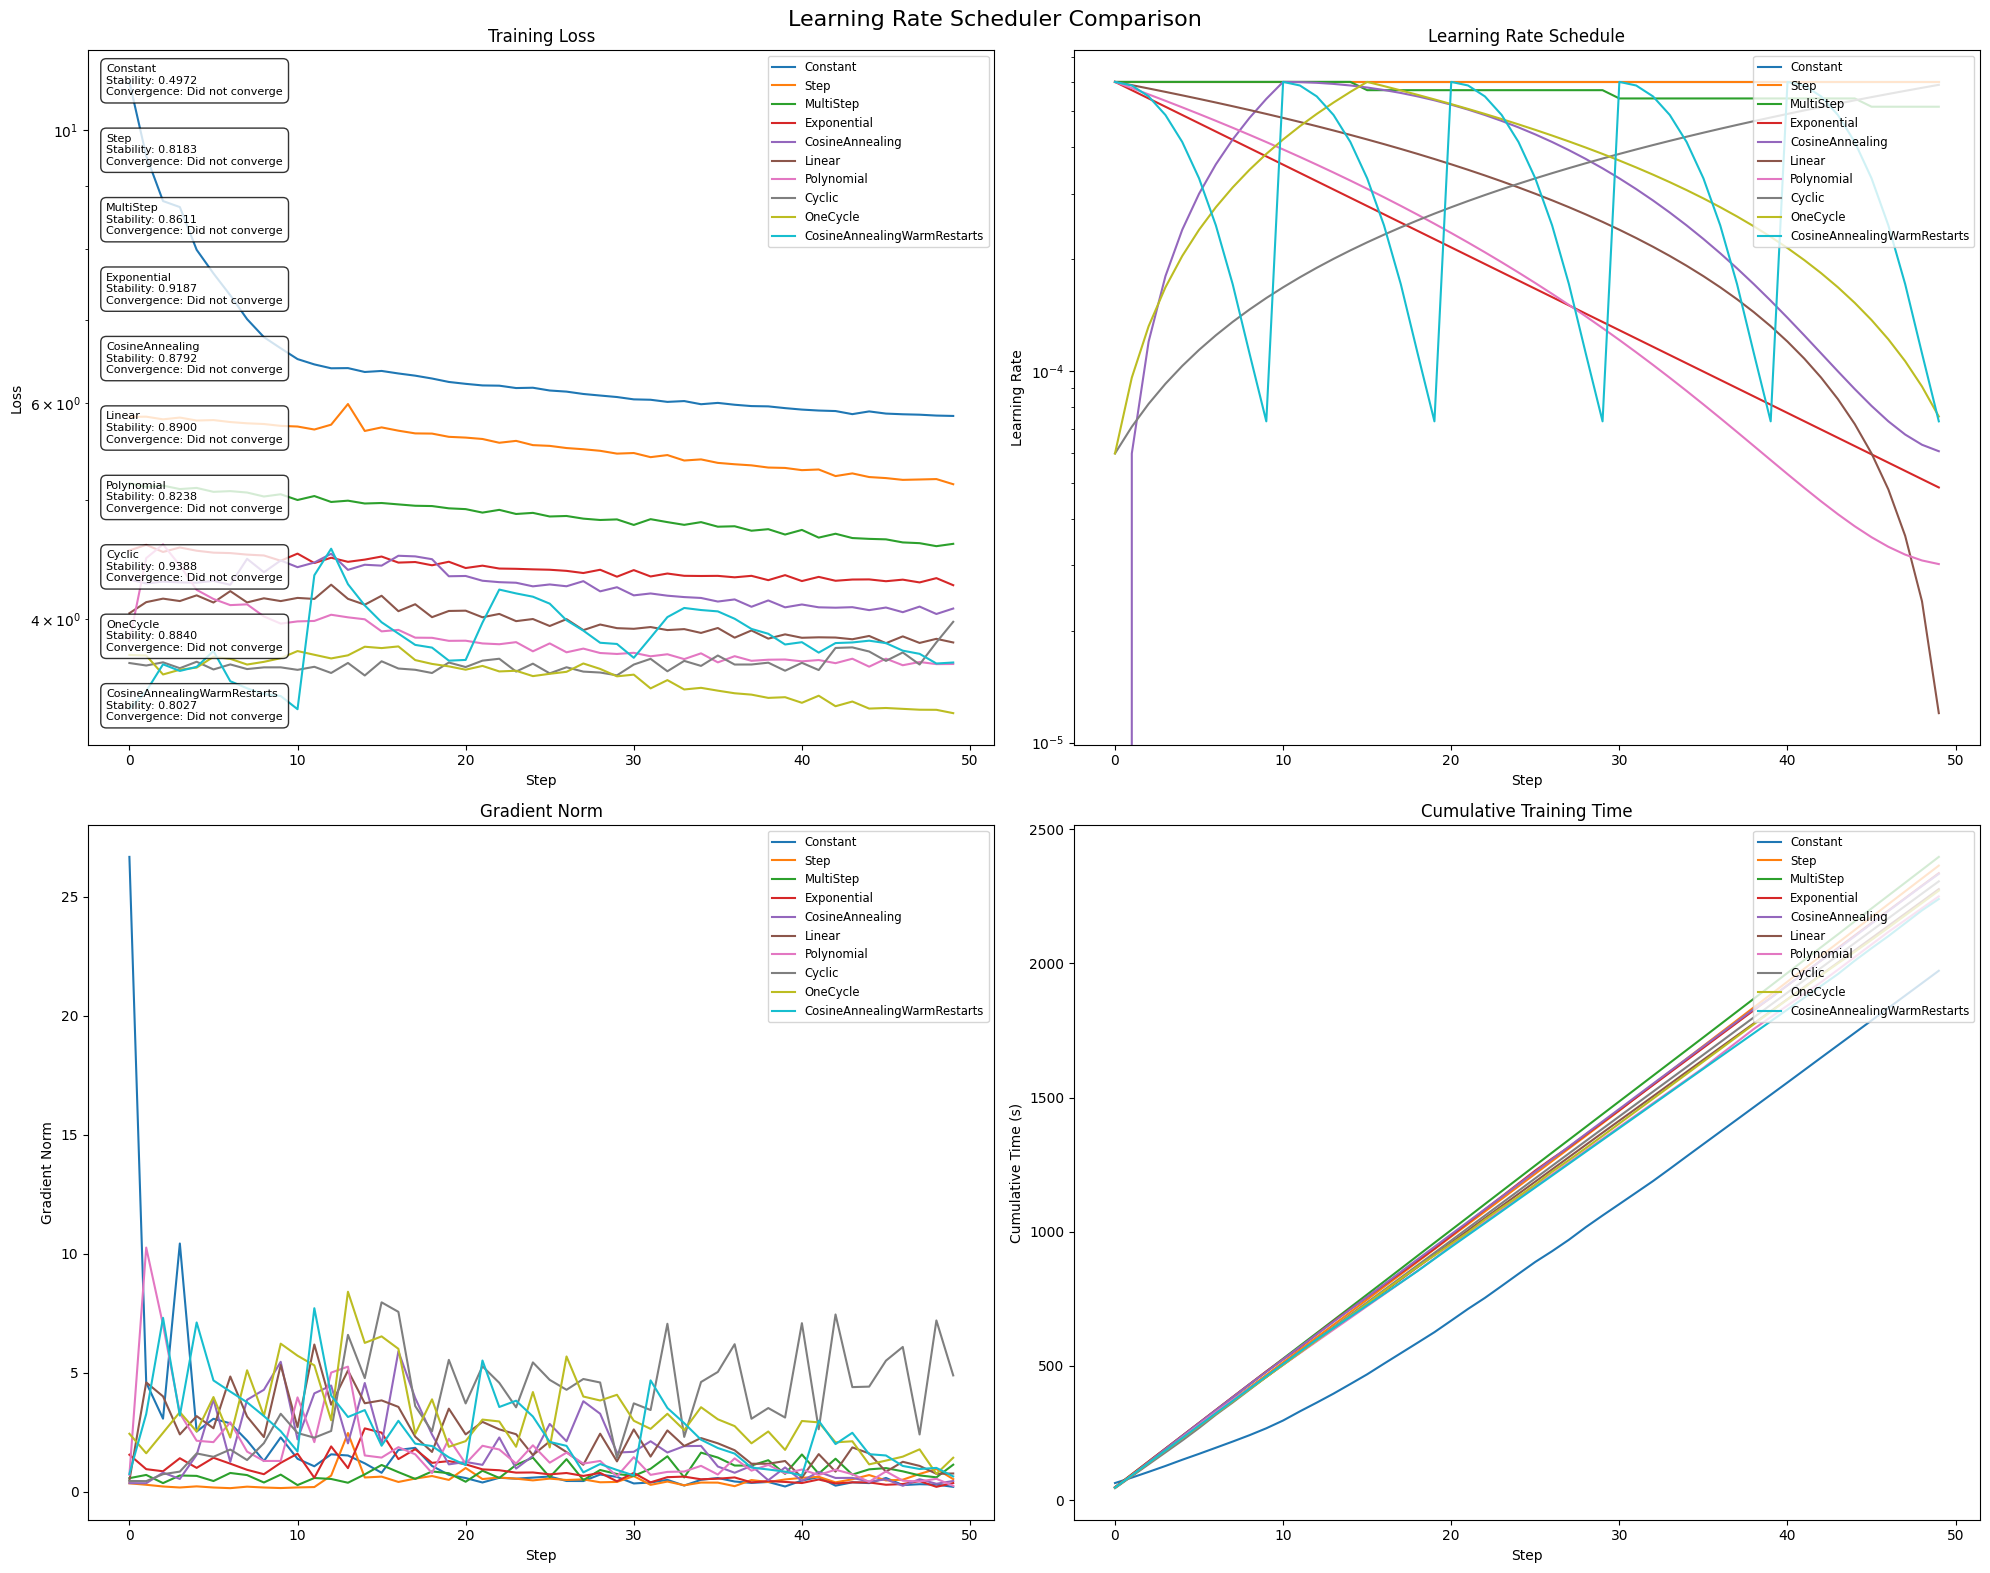

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(results, convergence_threshold):
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle("Learning Rate Scheduler Comparison", fontsize=16)

    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, data) in enumerate(results.items()):
        color = colors[idx]
        
        # Calculate stability score
        stability_score = 1 / (1 + np.std(data['losses']))
        
        # Find convergence step
        converged_step = next((i for i, loss in enumerate(data['losses']) 
                               if loss < convergence_threshold), None)
        convergence_text = f"Step {converged_step}" if converged_step is not None else "Did not converge"

        # Training Loss
        axs[0, 0].plot(data['losses'], color=color, label=name)
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].set_xlabel('Step')
        axs[0, 0].set_yscale('log')
        axs[0, 0].set_title('Training Loss')

        # Learning Rate Schedule
        axs[0, 1].plot(data['lrs'], color=color, label=name)
        axs[0, 1].set_ylabel('Learning Rate')
        axs[0, 1].set_xlabel('Step')
        axs[0, 1].set_yscale('log')
        axs[0, 1].set_title('Learning Rate Schedule')

        # Gradient Norm
        axs[1, 0].plot(data['norms'], color=color, label=name)
        axs[1, 0].set_ylabel('Gradient Norm')
        axs[1, 0].set_xlabel('Step')
        axs[1, 0].set_title('Gradient Norm')

        # Cumulative Training Time
        axs[1, 1].plot(np.cumsum(data['times']), color=color, label=name)
        axs[1, 1].set_ylabel('Cumulative Time (s)')
        axs[1, 1].set_xlabel('Step')
        axs[1, 1].set_title('Cumulative Training Time')

        # Add annotations for stability and convergence
        axs[0, 0].annotate(f"{name}\nStability: {stability_score:.4f}\nConvergence: {convergence_text}",
                           xy=(0.02, 0.98 - (idx * 0.1)), xycoords='axes fraction',
                           fontsize=8, ha='left', va='top',
                           bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

    # Add legends
    for ax in axs.flat:
        ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

plot_results(results, convergence_threshold=0.001)